#EOS491 - Assignment 3 - Matt Griffiths (V00752005)

In [1]:
import numpy as np
import numpy.linalg as la
import scipy.linalg as scla
import scipy as sc
import math as math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as P
import matplotlib.gridspec as gridspec
%matplotlib inline

Question 1

In [2]:
A = np.array([[1., 1., 1., 1., 1.], 
              [1., 1., 1., 1., 0.5], 
              [1., 1., 1., 0.5, 0.0],
              [1., 1., 0.5, 0.0, 0.0],
              [1., 0.5, 0.0, 0.0, 0.0],
              [0.5, 0.0, 0.0, 0.0, 0.0]])

mt = np.array([1, 2, 3, 4, 5])

dt = np.array([15., 12.5, 8., 4.5, 2., 0.5])

sig = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05]

Cd = np.zeros((6,6))
for i in range(0, len(sig), 1):
    Cd[i][i] = sig[i]**2

In [3]:
A2 = np.array([[1,1,1],[1,1,0]])
d2 = np.transpose(np.array([6,3]))
Cd2 = np.array([[0.3, 0.0],
               [0.0, 0.2]])

In [4]:
#SVD solver.
def getSvd(A):
    N = A.shape[0]
    M = A.shape[1]
    Uc, wc, Vc = la.svd(A, full_matrices=False)
    Wc = np.zeros((M,M))
    for i in range(0,len(wc),1):
        Wc[i][i] = wc[i]
    W = np.diag(wc)
    if(N>=M): 
        return Uc, Wc, Vc.T
    else: 
        return Uc, W, Vc.T

def genInv(U, W, V):
    Wi = W*1.
    for i in range(0, W.shape[0],1):
        if(W[i][i]<=0.000001):
            Wi[i][i] = 0.
        else: Wi[i][i] = 1./W[i][i]
    return np.dot(V,np.dot(Wi, U.T)), Wi

def svdSolve(d, Cd, A):
    S = la.cholesky(la.inv(Cd))
    U,W,V = getSvd(np.dot(S,A))
    Ag, Wi = genInv(U,W,V)
    m = np.dot(Ag, np.dot(S,d))
    return m, S, U, W, V, Wi

In [5]:
#Least squares solver.
def invertML(d, Cd, A):
    At = np.transpose(A)
    Cdi = la.inv(Cd)
    X = np.dot(At, Cdi)
    X = np.dot(X, A)
    X = la.inv(X)
    B = np.dot(At, Cdi)
    X = np.dot(X, B)
    m = np.dot(X, d)
    return m

In [6]:
#smallest solution solver.
def NormalSol(d, A):
    At = np.transpose(A)
    X = np.dot(A, At)
    X = la.inv(X)
    X = np.dot(At,X)
    m = np.dot(X, d)
    return m

In [8]:
print('\n SVD Pseudo-Inverse and Maximum Likely hood')
Msvd = svdSolve(dt, Cd, A)[0]
Mml = invertML(dt, Cd, A)

print('Parameter \t SVD \t ML')
print('---------------------------')
print('m1 \t\t ' + str(Msvd[0]) + '\t' + str(Mml[0]))
print('m2 \t\t ' + str(Msvd[1]) + '\t' + str(Mml[1]))
print('m3 \t\t ' + str(Msvd[2]) + '\t' + str(Mml[2]))
print('m4 \t\t ' + str(Msvd[3]) + '\t' + str(Mml[3]))
print('m5 \t\t ' + str(Msvd[4]) + '\t' + str(Mml[4]))
print('\n')

print('SVD Pseudo-Inverse and Smallest Solution')
Msvd = svdSolve(d2, Cd2, A2)[0]
Mns = NormalSol(d2, A2)

print('Parameter \t SVD \t Smallest')
print('---------------------------')
print('m1 \t\t ' + str(Msvd[0]) + '\t' + str(Mns[0]))
print('m2 \t\t ' + str(Msvd[1]) + '\t' + str(Mns[1]))
print('m3 \t\t ' + str(Msvd[2]) + '\t' + str(Mns[2]))


 SVD Pseudo-Inverse and Maximum Likely hood
Parameter 	 SVD 	 ML
---------------------------
m1 		 1.0	1.0
m2 		 2.0	2.0
m3 		 3.0	3.0
m4 		 4.0	4.0
m5 		 5.0	5.0


SVD Pseudo-Inverse and Smallest Solution
Parameter 	 SVD 	 Smallest
---------------------------
m1 		 1.5	1.5
m2 		 1.5	1.5
m3 		 3.0	3.0


SVD automatically does maximum likely hood and smallest solution without any exceptional case programming, that's great!

#Question 2

In [17]:
#Forward Problem.
def getA(layers, Rec, Source, x):
    rays = len(Source)*len(Rec)

    A = np.zeros(10)
    for k in range(0, len(Source)):
        A1 = np.zeros((len(Rec), layers))
        for i in range(0, len(Rec)):
            zsr = abs(Rec[i]-Source[k])
            sino = zsr/np.sqrt(x**2 + zsr**2)
            if(Rec[i]==Source[k]): A1[i][i+1] = x
            else:
                for j in range(0, layers):
                    if(5.+j*10.>Source[k] and 5.+j*10.<Rec[i]): 
                        A1[i][j] = 10./sino
                    elif(5.+j*10.<Source[k] and 5.+j*10.>Rec[i]): 
                        A1[i][j] = 10./sino 
        A = np.vstack((A, A1))
    return A[1:,:]

def getData(vel, rec, source, x):
    sl = 1./vel
    A = getA(len(vel), rec, source, x)
    return np.dot(A, sl.T)

def plotVel(vel, vlabel):
    depth = np.linspace(0, len(vel)*10., 10000)
    v = depth*0.
    for i in range(0, len(vel), 1):
        v[depth>=i*10] = vel[i]
    plt.plot(v, depth, 'k--', label=vlabel)
    plt.ylim(100, 0)
    plt.xlim(np.min(vel)-5., np.max(vel)+5.)
    plt.ylabel('depth [m]')
    plt.xlabel('velocity [m/s]')

def plotVeluncert(vel, vlabel, st):
    depth = np.linspace(0, len(vel)*10., 10000)
    v = depth*0.
    vst = depth*0.
    for i in range(0, len(vel), 1):
        v[depth>=i*10] = vel[i]
        vst[depth>=i*10] = np.sqrt(st[i][i])*vel[i]**2
    plt.fill_betweenx(depth, v-vst, v+vst, alpha=0.25)
    plt.plot(v, depth, label=vlabel)
    plt.ylim(100, 0)
    plt.xlim(np.min(vel)-5., np.max(vel)+5.)
    plt.ylabel('depth [m]')
    plt.xlabel('velocity [m/s]')
    
def plotMatrix(Ai, normtype):
    #normtype 1 normalizes whole matrix
    #normtype 2 normalizes rows of matrix
    
    N, M = Ai.shape
  
    if(normtype == 1):
        norm = np.max(abs(Ai))
        A = Ai/(norm*2)
    elif(normtype == 2):
        A = Ai*1.
        for i in range(0, N, 1):
            norm = np.max(abs(Ai[i,]))
            A[i,] = Ai[i,]/(norm*2)
    
    t = np.arange(1, M+1, 1)
    for i in range(0, N, 1):
        base = A[i,]*0.
        base.fill(N-i)
        plt.fill_between(t, base, A[i,]+base)
    plt.ylim(0,N+1)
    plt.axis('off')
    
def mkplot(velt, rec, source, x):
    layers = len(velt)
    dt = getData(velt, rec, source, x)
    d = dt + np.random.normal(0, 0.0001, len(dt))

    A1 = getA(layers, rec, source, x)
    Cd = 0.0000001*np.identity(len(d))
    m, S, U, W, V, Winv = svdSolve(d, Cd, A1)
    Cm = np.dot(V, np.dot(Winv, np.dot(Winv, V.T)))
#    for i in range(0, Cm.shape[0], 1):
#        for j in range(0, Cm.shape[1], 1):
#            Rm[i][j] = Cm[i][j]/np.sqrt(Cm[i][i]*Cm[j][j])
    index = np.arange(0,len(W),1)
    Wnorm = W/np.max(W)
    Rm = np.dot(V, V.T)
    Rm = np.dot(U.T, U)

    plt.figure(figsize=(20,10))
    ax1 = plt.subplot2grid((2,4), (0,0), rowspan=2)
    plotVel(velt, 'true velocity')
    #plotVel(1/m, 'inverted velocity')
    plotVeluncert(1/m, 'inverted velocity', Cm)
    ax1.set_xlim(1480, 1550)
    ax1.set_title('velocity')
    ax1.legend(loc=1)
    
    ax5 = plt.subplot2grid((2,4), (0,1), rowspan=2)
    cmstd = np.sqrt(np.diag(Cm))
    vstd = 0.*cmstd
    vel = 1./m
    for i, cm in enumerate(cmstd):
        vstd[i] = cm*vel[i]**2
    plotVel(vstd, 'uncertainty')
    ax5.set_title('velocity uncertainty')
    
    ax2 = plt.subplot2grid((2,4), (0,2))
    ax2.semilogy(index+1, Wnorm, 'bo')
    ax2.set_ylim(0.01, 2)
    ax2.set_xlim(0, len(Wnorm)+1)
    ax2.set_title('singular values')

    ax3 = plt.subplot2grid((2,4), (0,3))
    plotMatrix(A1, 1)
    plt.title('sensitivity matrix')

    ax4 = plt.subplot2grid((2,4), (1,2))
    plotMatrix(Cm, 2)
    plt.title('correlation matrix')

    ax5 = plt.subplot2grid((2,4), (1,3))
    plotMatrix(Rm, 2)
    plt.title('model resolution matrix')

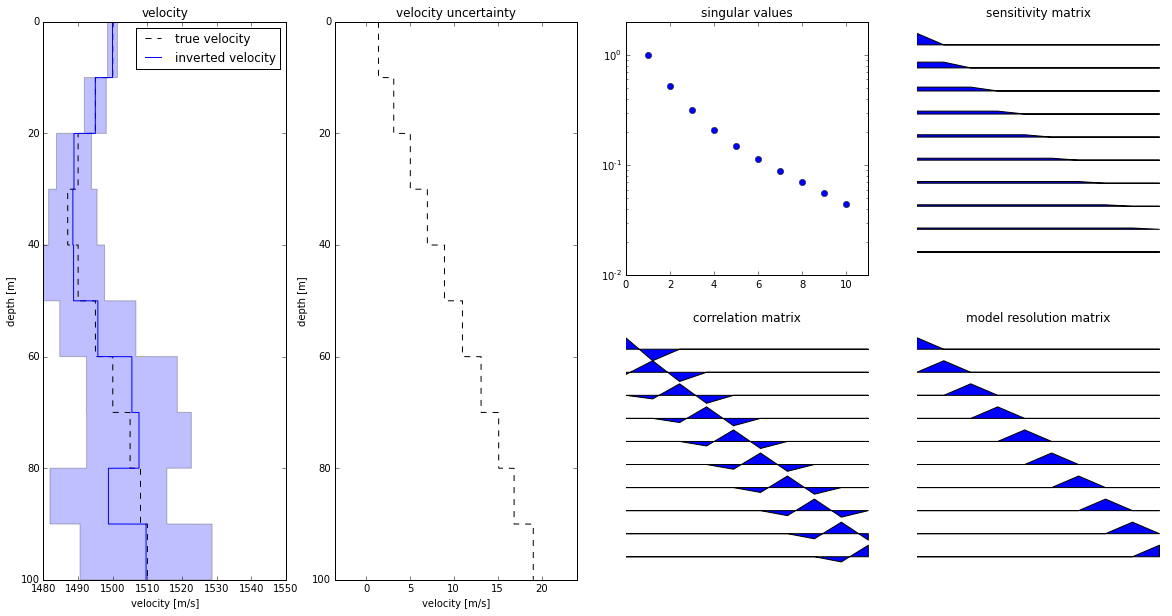

In [15]:
velt = np.array([1500., 1495., 1490., 1487., 1490., 1495., 1500., 1505., 1508., 1510.])
rec = np.linspace(10, 100, 10) 
source = np.array([0.])
x = 500

mkplot(velt, rec, source, x)
#plt.savefig('a3q2evendet.pdf')

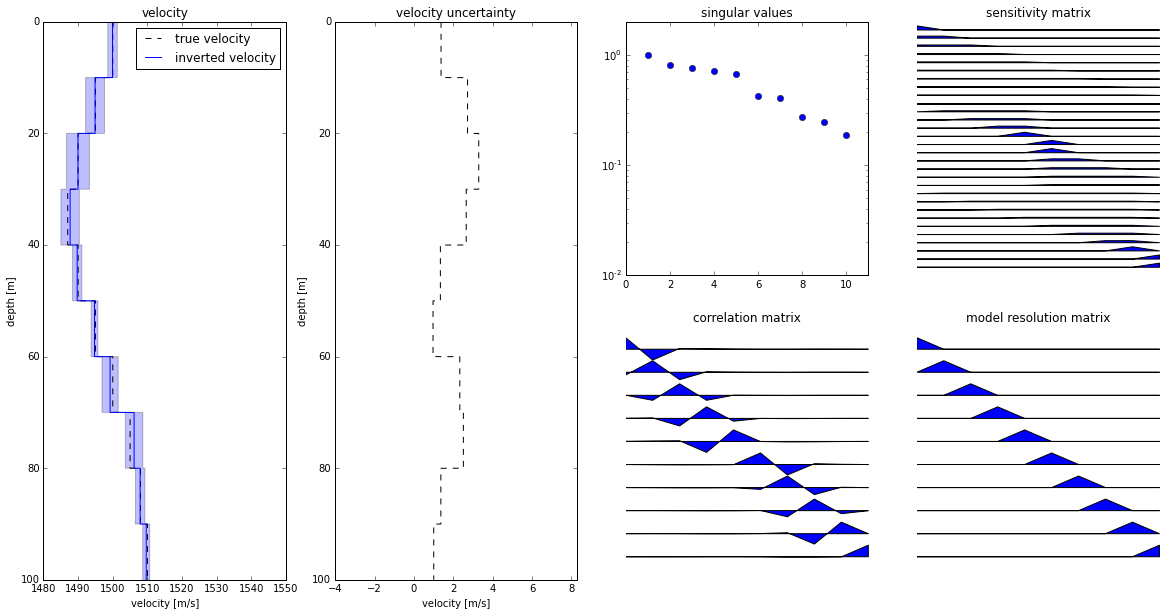

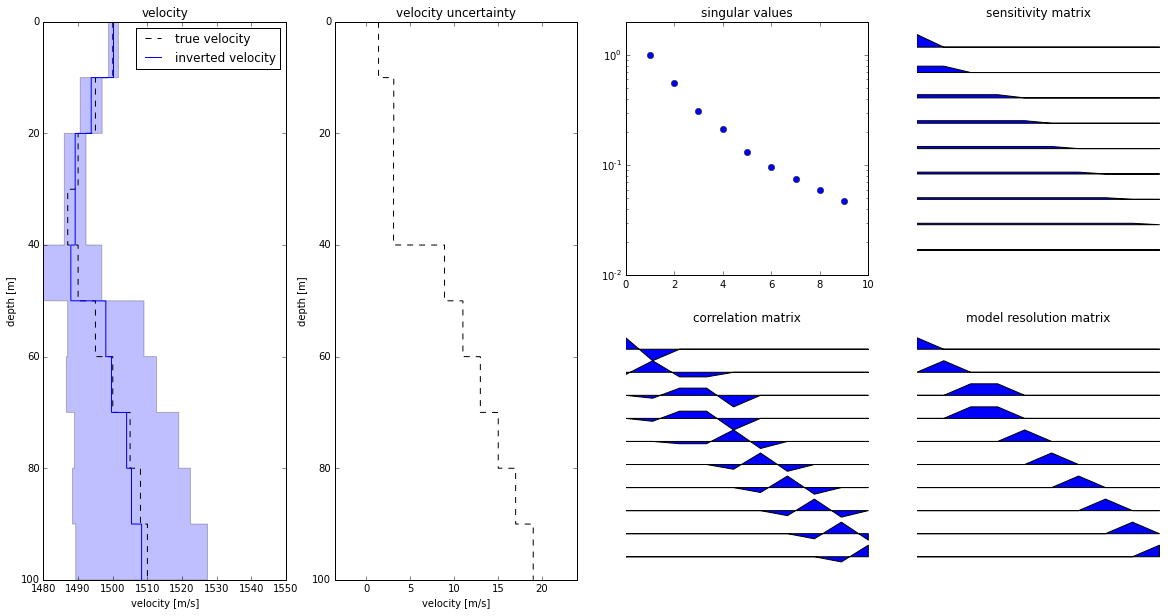

In [29]:
velt = np.array([1500., 1495., 1490., 1487., 1490., 1495., 1500., 1505., 1508., 1510.])
rec2 = np.linspace(10, 100, 10) 
source2 = np.array([0., 50., 90.])
x = 500
layers = 10

mkplot(velt, rec2, source2, x)
#plt.savefig('a3q2b.pdf')

rec3 = np.array([10., 20., 40., 50., 60., 70., 80., 90., 100.])
source3 = np.array([0.])
mkplot(velt, rec3, source3, x)
#plt.savefig('a3q2c.pdf')

In [11]:
#SVD solver.
def getSvd(A):
    N = A.shape[0]
    M = A.shape[1]
    Uc, wc, Vc = la.svd(A, full_matrices=True)
    wc = np.diag(wc)
    return Uc, wc, Vc.T

def genInv(U, W, V):
    Wi = W*1.
    for i in range(0, W.shape[0],1):
        if(W[i][i]<=0.000001):
            Wi[i][i] = 0.
        else: Wi[i][i] = 1./W[i][i]
    return np.dot(V,np.dot(Wi, U.T)), Wi

def svdSolve(d, Cd, A):
    S = la.cholesky(la.inv(Cd))
    U,W,V = getSvd(np.dot(S,A))
    Ag, Wi = genInv(U,W,V)
    m = np.dot(Ag, np.dot(S,d))
    return m, S, U, W, V, Wi

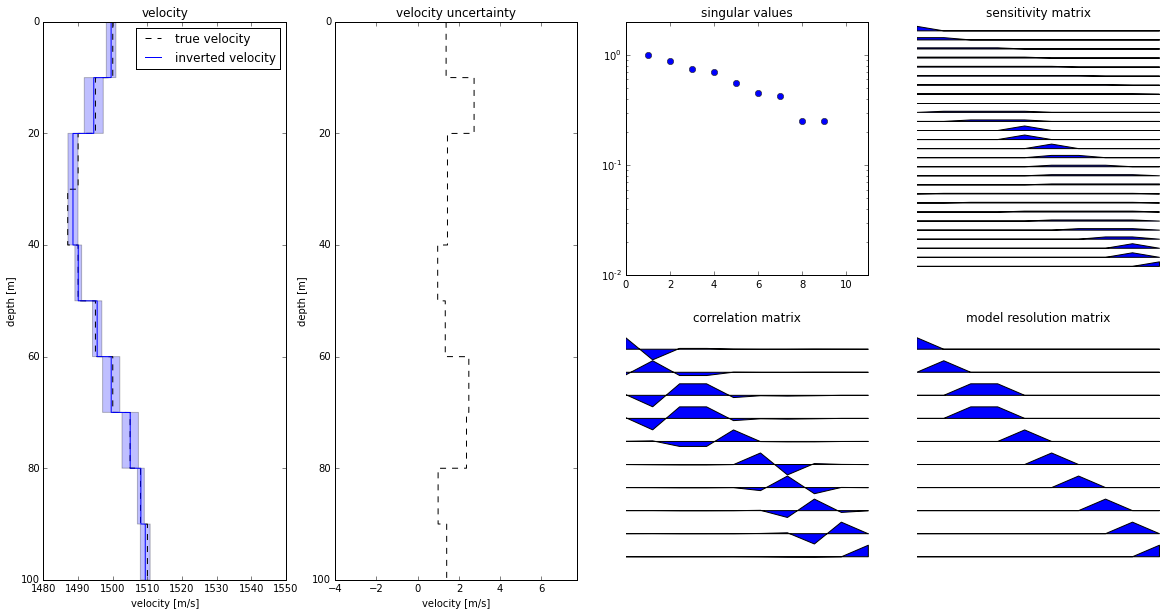

In [28]:
rec4 = np.array([10., 20., 40., 50., 60., 70., 80., 90., 100.])
source4 = np.array([0., 50., 90.])
mkplot2(velt, rec4, source4, x)


#plt.savefig('a3q2dsvd2.pdf')

In [27]:
def mkplot2(velt, rec, source, x):
    layers = len(velt)
    dt = getData(velt, rec, source, x)
    d = dt + np.random.normal(0, 0.0001, len(dt))

    A1 = getA(layers, rec, source, x)
    Cd = 0.0000001*np.identity(len(d))
    m, S, U, W, V, Winv = svdSolve(d, Cd, A1)
    Cm = np.dot(V, np.dot(Winv, np.dot(Winv, V.T)))
#    for i in range(0, Cm.shape[0], 1):
#        for j in range(0, Cm.shape[1], 1):
#            Rm[i][j] = Cm[i][j]/np.sqrt(Cm[i][i]*Cm[j][j])
    index = np.arange(0,len(W),1)
    Wnorm = W/np.max(W)
    #Rm = np.dot(V, V.T)
    #Rm = np.dot(U.T, U)

    plt.figure(figsize=(20,10))
    ax1 = plt.subplot2grid((2,4), (0,0), rowspan=2)
    plotVel(velt, 'true velocity')
    #plotVel(1/m, 'inverted velocity')
    plotVeluncert(1/m, 'inverted velocity', Cm)
    ax1.set_xlim(1480, 1550)
    ax1.set_title('velocity')
    ax1.legend(loc=1)
    
    ax5 = plt.subplot2grid((2,4), (0,1), rowspan=2)
    cmstd = np.sqrt(np.diag(Cm))
    vstd = 0.*cmstd
    vel = 1./m
    for i, cm in enumerate(cmstd):
        vstd[i] = cm*vel[i]**2
    plotVel(vstd, 'uncertainty')
    ax5.set_title('velocity uncertainty')
    
    ax2 = plt.subplot2grid((2,4), (0,2))
    ax2.semilogy(index+1, Wnorm, 'bo')
    ax2.set_ylim(0.01, 2)
    ax2.set_xlim(0, len(Wnorm)+1)
    ax2.set_title('singular values')

    ax3 = plt.subplot2grid((2,4), (0,3))
    plotMatrix(A1, 1)
    plt.title('sensitivity matrix')

    ax4 = plt.subplot2grid((2,4), (1,2))
    plotMatrix(Cm, 2)
    plt.title('correlation matrix')
    
    source = np.array([0.])
    dt = getData(velt, rec, source, x)
    d = dt + np.random.normal(0, 0.0001, len(dt))
    A1 = getA(layers, rec, source, x)
    Cd = 0.0000001*np.identity(len(d))
    m, S, U, W, V, Winv = svdSolve(d, Cd, A1)
    Cm = np.dot(V, np.dot(Winv, np.dot(Winv, V.T)))
#    for i in range(0, Cm.shape[0], 1):
#        for j in range(0, Cm.shape[1], 1):
#            Rm[i][j] = Cm[i][j]/np.sqrt(Cm[i][i]*Cm[j][j])
    index = np.arange(0,len(W),1)
    Wnorm = W/np.max(W)
    Rm = np.dot(V, V.T)
    
    
    ax5 = plt.subplot2grid((2,4), (1,3))
    plotMatrix(Rm, 2)
    plt.title('model resolution matrix')